## Load and prep columns

In [1]:
import xgboost as xgb
import numpy as np
import pandas as pd
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance
from matplotlib import pyplot
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from scipy import stats

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)


# Define columns
data_columns = ['symbol', 'quoteDate', 'adjustedPrice', 'volume', 'previousClose', 'change', 'changeInPercent', 
                '52WeekHigh', '52WeekLow', 'changeFrom52WeekHigh', 'changeFrom52WeekLow', 
                'percebtChangeFrom52WeekHigh', 'percentChangeFrom52WeekLow', 'Price200DayAverage', 
                'Price52WeekPercChange', '1WeekVolatility', '2WeekVolatility', '4WeekVolatility', '8WeekVolatility', 
                '12WeekVolatility', '26WeekVolatility','52WeekVolatility','4WeekBollingerPrediction', '4WeekBollingerType',
                '12WeekBollingerPrediction', '12WeekBollingerType', 'allordpreviousclose', 'allordchange', 
                'allorddayshigh', 'allorddayslow', 'allordpercebtChangeFrom52WeekHigh', 
                'allordpercentChangeFrom52WeekLow', 'asxpreviousclose', 'asxchange', 'asxdayshigh', 
                'asxdayslow', 'asxpercebtChangeFrom52WeekHigh', 'asxpercentChangeFrom52WeekLow', 'exDividendDate', 
                'exDividendPayout', '640106_A3597525W', 'AINTCOV', 'AverageVolume', 'BookValuePerShareYear', 
                'CashPerShareYear', 'DPSRecentYear', 'EBITDMargin', 'EPS', 'EPSGrowthRate10Years', 
                'EPSGrowthRate5Years', 'FIRMMCRT', 'FXRUSD', 'Float', 'GRCPAIAD', 'GRCPAISAD', 'GRCPBCAD', 
                'GRCPBCSAD', 'GRCPBMAD', 'GRCPNRAD', 'GRCPRCAD', 'H01_GGDPCVGDP', 'H01_GGDPCVGDPFY', 'H05_GLFSEPTPOP', 
                'IAD', 'LTDebtToEquityQuarter', 'LTDebtToEquityYear', 'MarketCap',
                'NetIncomeGrowthRate5Years', 'NetProfitMarginPercent', 'OperatingMargin', 'PE',
                'PriceToBook', 'ReturnOnAssets5Years', 'ReturnOnAssetsTTM', 'ReturnOnAssetsYear', 
                'ReturnOnEquity5Years', 'ReturnOnEquityTTM', 'ReturnOnEquityYear', 'RevenueGrowthRate10Years', 
                'RevenueGrowthRate5Years', 'TotalDebtToAssetsQuarter', 'TotalDebtToAssetsYear', 
                'TotalDebtToEquityQuarter', 'TotalDebtToEquityYear', 'bookValue', 'earningsPerShare', 
                'ebitda', 'epsEstimateCurrentYear', 'marketCapitalization', 'peRatio', 'pegRatio', 'pricePerBook', 
                'pricePerEpsEstimateCurrentYear', 'pricePerEpsEstimateNextYear', 'pricePerSales']

returns = {
    '1': 'Future1WeekReturn',
    '2': 'Future2WeekReturn',
    '4': 'Future4WeekReturn',
    '8': 'Future8WeekReturn',
    '12': 'Future12WeekReturn',
    '26': 'Future26WeekReturn',
    '52': 'Future52WeekReturn',
    '1ra': 'Future1WeekRiskAdjustedReturn',
    '2ra': 'Future2WeekRiskAdjustedReturn',
    '4ra': 'Future4WeekRiskAdjustedReturn',
    '8ra': 'Future8WeekRiskAdjustedReturn',
    '12ra': 'Future12WeekRiskAdjustedReturn',
    '26ra': 'Future26WeekRiskAdjustedReturn',
    '52ra': 'Future52WeekRiskAdjustedReturn'
}

# Load data
raw_data = pd.read_csv('data/companyQuotes-20170417-001.csv')
raw_data.head(5)

/Users/neilkloot/anaconda/lib/python3.6/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/neilkloot/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,symbol,quoteDate,lastTradePriceOnly,adjustedPrice,volume,daysHigh,daysLow,previousClose,change,changeInPercent,52WeekHigh,52WeekLow,changeFrom52WeekHigh,changeFrom52WeekLow,percebtChangeFrom52WeekHigh,percentChangeFrom52WeekLow,Price200DayAverage,Price52WeekPercChange,1WeekVolatility,2WeekVolatility,4WeekVolatility,8WeekVolatility,12WeekVolatility,26WeekVolatility,52WeekVolatility,4WeekBollingerBandLower,4WeekBollingerBandUpper,4WeekBollingerPrediction,4WeekBollingerType,12WeekBollingerBandLower,12WeekBollingerBandUpper,12WeekBollingerPrediction,12WeekBollingerType,allordpreviousclose,allordchange,allorddayshigh,allorddayslow,allordpercebtChangeFrom52WeekHigh,allordpercentChangeFrom52WeekLow,asxpreviousclose,asxchange,asxdayshigh,asxdayslow,asxpercebtChangeFrom52WeekHigh,asxpercentChangeFrom52WeekLow,exDividendDate,exDividendPayout,640106_A3597525W,AINTCOV,AverageVolume,Beta,BookValuePerShareYear,CashPerShareYear,DPSRecentYear,EBITDMargin,EPS,EPSGrowthRate10Years,EPSGrowthRate5Years,FIRMMCRT,FXRUSD,Float,GRCPAIAD,GRCPAISAD,GRCPBCAD,GRCPBCSAD,GRCPBMAD,GRCPNRAD,GRCPRCAD,H01_GGDPCVGDP,H01_GGDPCVGDPFY,H05_GLFSEPTPOP,IAD,LTDebtToEquityQuarter,LTDebtToEquityYear,MarketCap,NetIncomeGrowthRate5Years,NetProfitMarginPercent,OperatingMargin,PE,PriceToBook,QuoteLast,ReturnOnAssets5Years,ReturnOnAssetsTTM,ReturnOnAssetsYear,ReturnOnEquity5Years,ReturnOnEquityTTM,ReturnOnEquityYear,RevenueGrowthRate10Years,RevenueGrowthRate5Years,TotalDebtToAssetsQuarter,TotalDebtToAssetsYear,TotalDebtToEquityQuarter,TotalDebtToEquityYear,bookValue,earningsPerShare,ebitda,epsEstimateCurrentYear,marketCapitalization,peRatio,pegRatio,pricePerBook,pricePerEpsEstimateCurrentYear,pricePerEpsEstimateNextYear,pricePerSales,Future1WeekDividend,Future1WeekPrice,Future1WeekReturn,Future1WeekRiskAdjustedReturn,Future2WeekDividend,Future2WeekPrice,Future2WeekReturn,Future2WeekRiskAdjustedReturn,Future4WeekDividend,Future4WeekPrice,Future4WeekReturn,Future4WeekRiskAdjustedReturn,Future8WeekDividend,Future8WeekPrice,Future8WeekReturn,Future8WeekRiskAdjustedReturn,Future12WeekDividend,Future12WeekPrice,Future12WeekReturn,Future12WeekRiskAdjustedReturn,Future26WeekDividend,Future26WeekPrice,Future26WeekReturn,Future26WeekRiskAdjustedReturn,Future52WeekDividend,Future52WeekPrice,Future52WeekReturn,Future52WeekRiskAdjustedReturn
0,CCA,2016-06-30,0.560,0.560,1876700,0.770,0.535,0.765,-0.205,-0.267974,0.56,0.560,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.560000,0.560000,Steady,Within,0.560000,0.560000,Steady,Within,5221.000000,41.299805,5324.399902,5221.000000,-0.082183,0.083960,5142.399902,39.100097,5247.600098,5142.399902,-0.098884,0.079135,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,NaN,NaN,-30.8,NaN,NaN,1.77,0.7426,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.55,-1.785714,-7.688946,NaN,0.65,16.071429,2.693578,NaN,0.64,14.285714,2.260607,NaN,0.61,8.928571,1.801456,NaN,0.54,-3.571429,-19.327464,NaN,0.56,NaN,NaN,NaN,NaN,NaN,NaN
1,CCA,2016-07-01,0.590,0.590,985000,0.625,0.500,0.515,0.075,0.145631,0.59,0.560,0.000,0.03,0.000000,0.053571,NaN,NaN,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.015000,0.545000,0.605000,Steady,Within,0.545000,0.605000,Steady,Within,5310.399902,89.399902,5356.500000,5310.399902,-0.066467,0.102520,5233.399902,91.000000,5278.899902,5233.399902,-0.082938,0.098231,NaN,NaN,108.2,3828.0,NaN,NaN,0.24,-0.213,0.0,NaN,-30.8,NaN,NaN,1.77,0.7460,63500000.0,87.307409,89.957900,87.425456,92.706255,87.037799,85.756318,96.070719,412937.0,1.227102,61.092677,NaN,NaN,NaN,36000000.0,NaN,NaN,-4147.2,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-67.4,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.54,-8.474576,-33.621753,0.0,0.65,10.169492,1.644524,0.0,0.67,13.559322,2.167481,0.0,0.60,1.694915,0.343165,0.0,0.52,-11.864407,-65.4875

-----
Future1WeekReturn


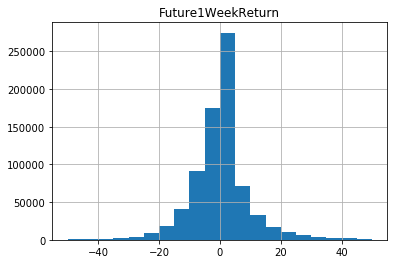

Instances:  771258
Mean:  0.9528324226271839
Min:  -99.92
25th percentile:  -4.166477525538371
Median:  0.0
75th percentile:  3.532008830022078
Max:  49900.0
Std deviation:  104.66549770977275
Variance:  10954.866410834444
Skew:  436.159213561
-----
Future2WeekReturn


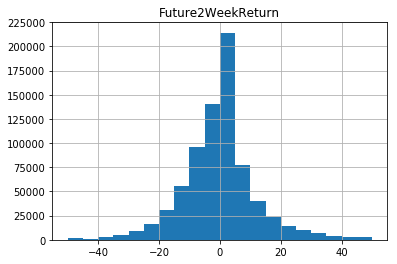

Instances:  768178
Mean:  1.5674015114507465
Min:  -99.96
25th percentile:  -6.245232613447025
Median:  0.0
75th percentile:  5.041693008332588
Max:  49900.0
Std deviation:  139.03169348008464
Variance:  19329.811791940214
Skew:  297.834554507
-----
Future4WeekReturn


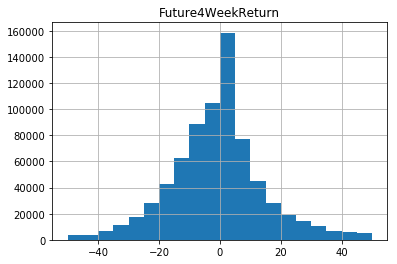

Instances:  763906
Mean:  4.1888037099139845
Min:  -99.96
25th percentile:  -9.22506201958628
Median:  0.0
75th percentile:  7.331410031814271
Max:  756799.988323
Std deviation:  1233.0148875735952
Variance:  1520325.7129781258
Skew:  605.800027354
-----
Future8WeekReturn


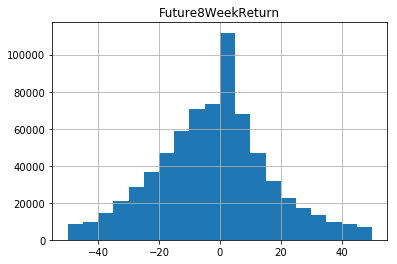

Instances:  756392
Mean:  10.807468561642954
Min:  -99.96
25th percentile:  -14.000238270449735
Median:  -0.3624301395888254
75th percentile:  10.684926885952233
Max:  756799.988323
Std deviation:  2347.7533138441677
Variance:  5511945.6226662705
Skew:  315.554453483
-----
Future12WeekReturn


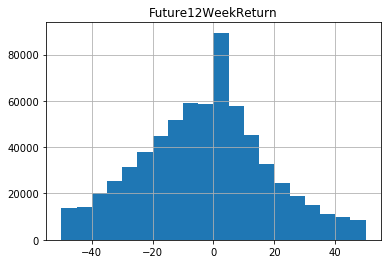

Instances:  747849
Mean:  5.044182765580537
Min:  -99.96
25th percentile:  -17.72727272727273
Median:  -0.9523809523809532
75th percentile:  13.380335005204895
Max:  756799.988323
Std deviation:  887.0880104726973
Variance:  786925.1383244083
Skew:  831.049346497
-----
Future26WeekReturn


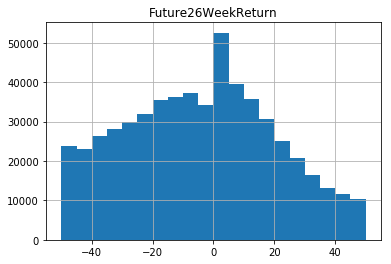

Instances:  719078
Mean:  14.013828354253457
Min:  -99.96
25th percentile:  -29.09090909090909
Median:  -3.124999999999991
75th percentile:  20.138132463997856
Max:  756799.988323
Std deviation:  2367.166778392296
Variance:  5603478.556724161
Skew:  318.149056804
-----
Future52WeekReturn


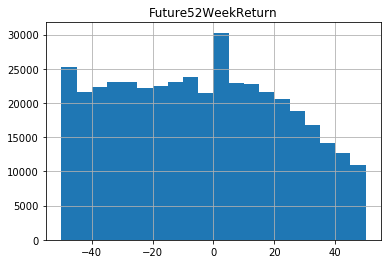

Instances:  673719
Mean:  14.879184180324275
Min:  -99.95
25th percentile:  -44.92753623188405
Median:  -7.6923076923076845
75th percentile:  29.25812356979406
Max:  756799.988323
Std deviation:  1407.3150161334056
Variance:  1980535.5546345678
Skew:  491.273662584
-----
Future1WeekRiskAdjustedReturn


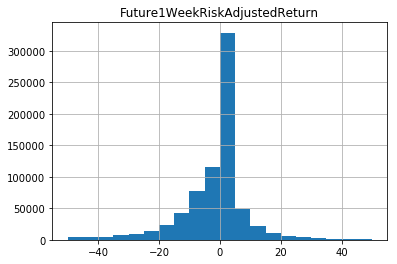

Instances:  771258
Mean:  -78.26455502861815
Min:  -1382846.03289
25th percentile:  -6.832447236429337
Median:  0.0
75th percentile:  1.451068071072563
Max:  49900.0
Std deviation:  4683.006595319819
Variance:  21930550.771808922
Skew:  -187.833491937
-----
Future2WeekRiskAdjustedReturn


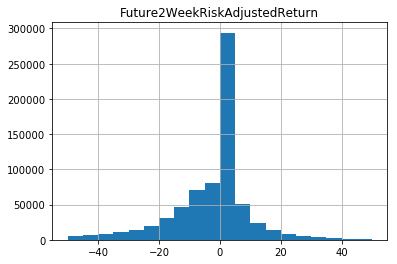

Instances:  768178
Mean:  -165.61464154826493
Min:  -2899932.31611
25th percentile:  -11.538461538461537
Median:  0.0
75th percentile:  1.707451387294313
Max:  49900.0
Std deviation:  8654.449381380411
Variance:  74899494.09487578
Skew:  -163.439223881
-----
Future4WeekRiskAdjustedReturn


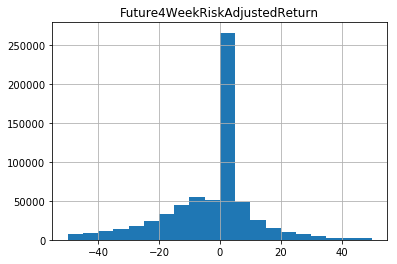

Instances:  763906
Mean:  -342.547933218426
Min:  -3557915.1663
25th percentile:  -20.0
Median:  0.0
75th percentile:  1.9156917902369668
Max:  49900.0
Std deviation:  13984.175239083765
Variance:  195557157.11740348
Skew:  -100.363477268
-----
Future8WeekRiskAdjustedReturn


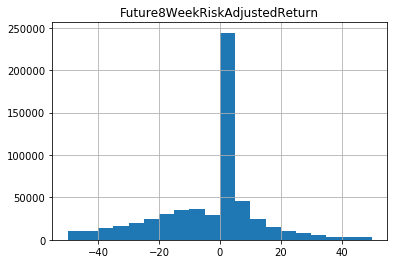

Instances:  756392
Mean:  -727.8327938768274
Min:  -3528491.86758
25th percentile:  -34.436030290952566
Median:  -1.1325528539414425
75th percentile:  2.0855848055549266
Max:  6527.29912007
Std deviation:  24906.255410091584
Variance:  620321558.5527163
Skew:  -80.5384093317
-----
Future12WeekRiskAdjustedReturn


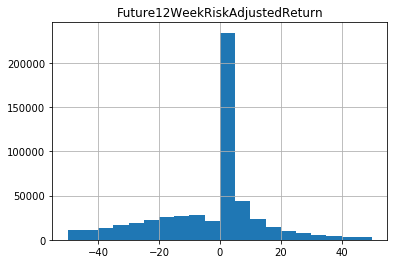

Instances:  747849
Mean:  -1160.2322910315424
Min:  -5821606.61635
25th percentile:  -49.71318323553252
Median:  -2.631578947368428
75th percentile:  2.1381167989637078
Max:  7650.60642153
Std deviation:  36368.59369009342
Variance:  1322674606.9951026
Skew:  -65.2468324392
-----
Future26WeekRiskAdjustedReturn


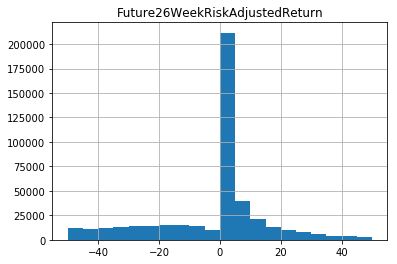

Instances:  719078
Mean:  -2813.661358678318
Min:  -6153055.23285
25th percentile:  -115.86049359504666
Median:  -8.602150537634401
75th percentile:  2.117613272331397
Max:  5192.97417288
Std deviation:  74901.56182584529
Variance:  5610243963.950925
Skew:  -53.4672593881
-----
Future52WeekRiskAdjustedReturn


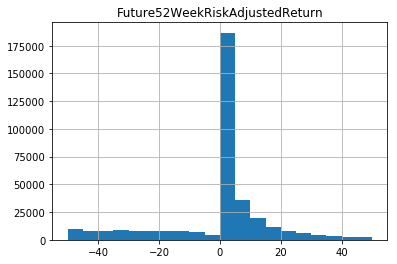

Instances:  673719
Mean:  -6095.747859498521
Min:  -10549910.9918
25th percentile:  -262.7730069628771
Median:  -24.137507452679205
75th percentile:  1.8969033890460054
Max:  5400.0
Std deviation:  153527.54599520273
Variance:  23570707379.309093
Skew:  -46.8673808663


In [2]:
# Plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    raw_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0, 
                                            5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', raw_data[return_column].count())
    print('Mean: ', raw_data[return_column].mean())
    print('Min: ', raw_data[return_column].min())
    print('25th percentile: ', raw_data[return_column].quantile(0.25))
    print('Median: ', raw_data[return_column].median())
    print('75th percentile: ', raw_data[return_column].quantile(0.75))
    print('Max: ', raw_data[return_column].max())
    print('Std deviation: ', raw_data[return_column].std())
    print('Variance: ', raw_data[return_column].var())
    print('Skew: ', raw_data[return_column].skew())

In [57]:
# Set target column
target_column = returns['8']


In [ ]:
# Check outliers
outliers = raw_data.loc[(raw_data[target_column] > 100) | (raw_data[target_column] < -50)]
print(len(outliers))

exclude_symbols = outliers['symbol'].unique()

In [50]:
# Remove rows in the excluded symbols list
filtered_data = raw_data[~raw_data['symbol'].isin(exclude_symbols)]


-----
Future1WeekReturn


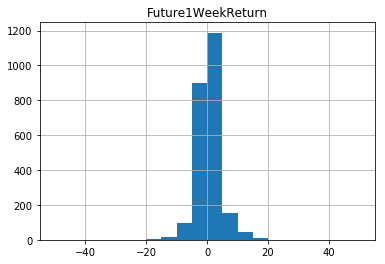

Instances:  2413
Mean:  0.5795607336304631
Min:  -19.8902908284
25th percentile:  -1.3834548326567382
Median:  0.5175814170697692
75th percentile:  2.3173709050514386
Max:  19.5788558829
Std deviation:  3.7981427218138943
Variance:  14.425888135267856
Skew:  0.336593854071
-----
Future2WeekReturn


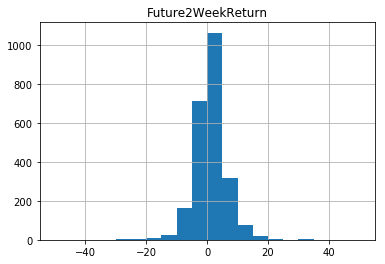

Instances:  2408
Mean:  1.1506085816307166
Min:  -27.9903406666
25th percentile:  -1.679830803401422
Median:  1.1041907699951972
75th percentile:  3.6371918715204625
Max:  31.6820123574
Std deviation:  5.153589087142109
Variance:  26.55948047911024
Skew:  0.191951560893
-----
Future4WeekReturn


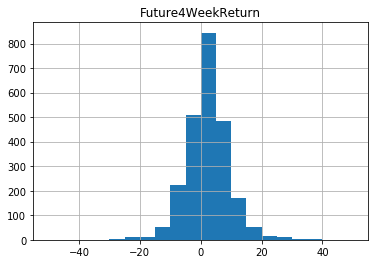

Instances:  2398
Mean:  2.2699618264223047
Min:  -30.3079927348
25th percentile:  -1.769784198981689
Median:  2.3969713381170936
75th percentile:  5.930667545028312
Max:  42.991571162
Std deviation:  7.1426466906139785
Variance:  51.017401746938816
Skew:  0.263341619038
-----
Future8WeekReturn


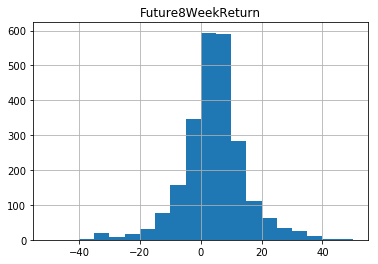

Instances:  2381
Mean:  4.496539092785687
Min:  -35.99032483
25th percentile:  -0.5650378929558242
Median:  4.612286042180928
75th percentile:  9.158623494424782
Max:  62.3992204158
Std deviation:  10.53658746848794
Variance:  111.01967548109711
Skew:  0.159243481089
-----
Future12WeekReturn


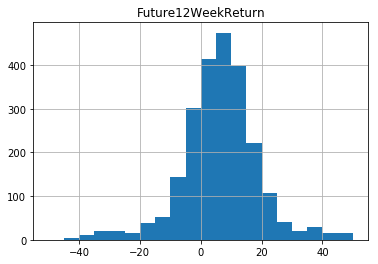

Instances:  2362
Mean:  6.663415985005471
Min:  -42.4712485613
25th percentile:  -0.16111039148046408
Median:  6.7212461964796075
75th percentile:  13.130785572169566
Max:  75.5420442431
Std deviation:  13.337516777477674
Variance:  177.88935378949844
Skew:  0.176164187655
-----
Future26WeekReturn


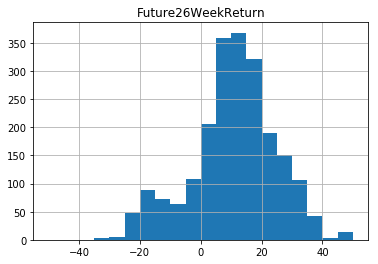

Instances:  2291
Mean:  14.001686927029626
Min:  -31.9479874155
25th percentile:  4.751385837037052
Median:  12.822259033471642
75th percentile:  21.746949014914772
Max:  90.255783715
Std deviation:  18.719017146815855
Variance:  350.401602942786
Skew:  0.852441448352
-----
Future52WeekReturn


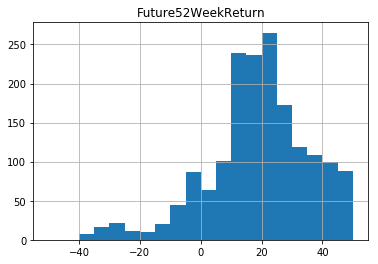

Instances:  2168
Mean:  30.537804024516937
Min:  -35.746219474
25th percentile:  13.377917419009446
Median:  24.02604733777376
75th percentile:  45.13745634556139
Max:  180.261443897
Std deviation:  29.72947277241372
Variance:  883.8415513256889
Skew:  1.28391084778
-----
Future1WeekRiskAdjustedReturn


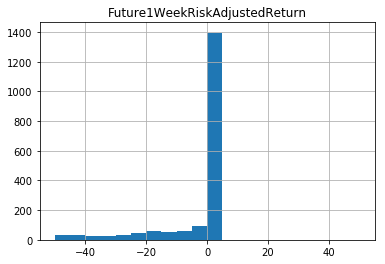

Instances:  2413
Mean:  -61.595680859722194
Min:  -2083.81423164
25th percentile:  -44.16150629927441
Median:  0.017535736853303785
75th percentile:  0.06529282319542011
Max:  1.00864199634
Std deviation:  173.03790874718368
Variance:  29942.11786359867
Skew:  -5.56476084523
-----
Future2WeekRiskAdjustedReturn


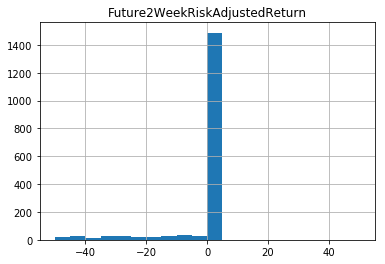

Instances:  2408
Mean:  -111.4278131992434
Min:  -5229.33661989
25th percentile:  -75.55079738242434
Median:  0.02406584840775796
75th percentile:  0.0711793903904334
Max:  0.934089737098
Std deviation:  332.11226007437784
Variance:  110298.5532917112
Skew:  -7.3958718781
-----
Future4WeekRiskAdjustedReturn


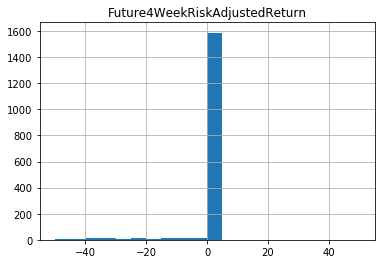

Instances:  2398
Mean:  -193.80769386263555
Min:  -6209.70453171
25th percentile:  -118.615534922488
Median:  0.03148281704373425
75th percentile:  0.08070950787907465
Max:  0.884165261084
Std deviation:  539.0125433111695
Variance:  290534.5218467753
Skew:  -5.13879794272
-----
Future8WeekRiskAdjustedReturn


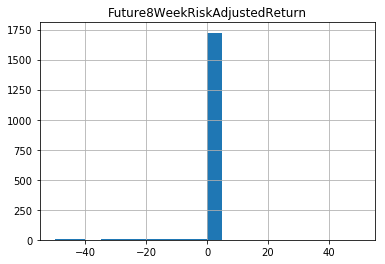

Instances:  2381
Mean:  -341.6524685632562
Min:  -8432.0433443
25th percentile:  -46.923044376257934
Median:  0.04052256476339188
75th percentile:  0.09131032974157044
Max:  0.497064572755
Std deviation:  1053.889283262483
Variance:  1110682.6213755105
Skew:  -4.49600337213
-----
Future12WeekRiskAdjustedReturn


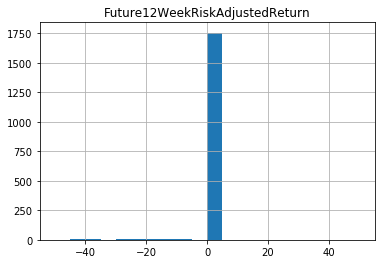

Instances:  2362
Mean:  -475.59282547605847
Min:  -12126.4411308
25th percentile:  -19.65745477973084
Median:  0.04990332823727964
75th percentile:  0.10906480143922948
Max:  0.40766712394
Std deviation:  1497.558812914338
Variance:  2242682.398137401
Skew:  -4.42099424519
-----
Future26WeekRiskAdjustedReturn


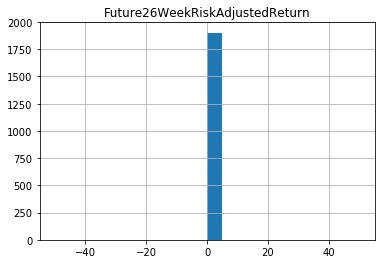

Instances:  2291
Mean:  -570.9817322238885
Min:  -10208.9359456
25th percentile:  0.020985789664765976
Median:  0.06575407073612187
75th percentile:  0.12258389111139639
Max:  0.426249420879
Std deviation:  1625.3872997342437
Variance:  2641883.874137376
Skew:  -3.03107883971
-----
Future52WeekRiskAdjustedReturn


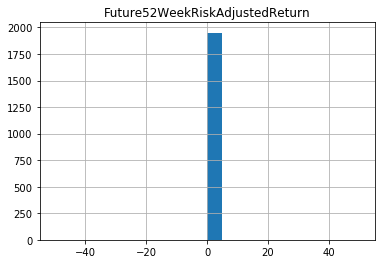

Instances:  2168
Mean:  -336.53098031038576
Min:  -9414.05354805
25th percentile:  0.04475537563379915
Median:  0.09842931216826489
75th percentile:  0.1492463881652327
Max:  0.335084827354
Std deviation:  1339.7106203267417
Variance:  1794824.546216263
Skew:  -4.74404008021


In [58]:
# Re-plot values for each potential target
for key in returns:
    print('-----')
    return_column = returns[key]
    print(return_column)
    filtered_data.hist(column=return_column,bins=[-50, -45, -40, -35, -30, -25, -20, -15, -10, -5, 0,
                                                  5, 10, 15, 20, 25, 30, 35, 40, 45, 50])
    pyplot.show()


    print('Instances: ', filtered_data[return_column].count())
    print('Mean: ', filtered_data[return_column].mean())
    print('Min: ', filtered_data[return_column].min())
    print('25th percentile: ', filtered_data[return_column].quantile(0.25))
    print('Median: ', filtered_data[return_column].median())
    print('75th percentile: ', filtered_data[return_column].quantile(0.75))
    print('Max: ', filtered_data[return_column].max())
    print('Std deviation: ', filtered_data[return_column].std())
    print('Variance: ', filtered_data[return_column].var())
    print('Skew: ', filtered_data[return_column].skew())


In [59]:
# Remove rows missing the target column
filtered_data = filtered_data.dropna(subset=[target_column], how='all')

# Create y_data
y_data = filtered_data[target_column].values


# Filter down data to the X columns being used
filtered_data = filtered_data[data_columns]


print(filtered_data.dtypes)

print('Min:',min(y_data),', Max:', max(y_data))

symbol                                object
quoteDate                             object
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
4WeekBolli

In [60]:
from datetime import datetime as dt
from dateutil.parser import parse

def is_date(string):
    try: 
        parse(string)
        return True
    except:
        return False

def convert_date_to_ordinal(date_val):
    if(pd.isnull(date_val)):
        return -99999
    
    elif(type(date_val) is str):
        if(is_date(date_val)):
            return parse(date_val).toordinal()
        else:
            return -99999

    elif(type(date_val) is int or type(date_val) is float):
        return date_val
    

# Fix date values - convert to ordinals
filtered_data['quoteDate'] = filtered_data['quoteDate'].apply(lambda x: convert_date_to_ordinal(x))

# print(filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x)))
filtered_data['exDividendDate'] = filtered_data['exDividendDate'].apply(lambda x: convert_date_to_ordinal(x))

print(filtered_data.head(5))

# Convert categorical variables to boolean fields
#  4WeekBollingerPrediction              
#  4WeekBollingerType                    
#  12WeekBollingerPrediction             
#  12WeekBollingerType                   

filtered_data = pd.get_dummies(data=filtered_data, columns=['symbol', '4WeekBollingerPrediction', '4WeekBollingerType', 
                                                            '12WeekBollingerPrediction', '12WeekBollingerType'])


# Fill nan values with placeholder and check for null values
filtered_data = filtered_data.fillna(-99999)
print(pd.isnull(filtered_data).any())

       symbol  quoteDate  adjustedPrice   volume  previousClose  change  \
211629    CBA     732859       23.97797  3081100        55.0020 -0.6167   
211630    CBA     732860       23.98675  2900300        54.6937 -0.2885   
211631    CBA     732861       23.85959  1648100        54.6041 -0.4873   
211632    CBA     732862       24.16218  2846600        54.2063  0.5968   
211633    CBA     732863       24.24110  2584700        54.7036  0.2785   

        changeInPercent  52WeekHigh  52WeekLow  changeFrom52WeekHigh  \
211629        -0.011212    24.57436   17.56405              -0.59639   
211630        -0.005275    24.57436   17.56405              -0.58761   
211631        -0.008924    24.57436   17.56405              -0.71477   
211632         0.011010    24.57436   17.56405              -0.41218   
211633         0.005091    24.57436   17.56405              -0.33326   

        changeFrom52WeekLow  percebtChangeFrom52WeekHigh  \
211629              6.41392                    -0.024269

In [61]:
# Check data types
print(filtered_data.dtypes)

# Copy over X_data columns
X_data = filtered_data.values


# View some sample records
print(X_data[range(0,5)])


quoteDate                              int64
adjustedPrice                        float64
volume                                 int64
previousClose                        float64
change                               float64
changeInPercent                      float64
52WeekHigh                           float64
52WeekLow                            float64
changeFrom52WeekHigh                 float64
changeFrom52WeekLow                  float64
percebtChangeFrom52WeekHigh          float64
percentChangeFrom52WeekLow           float64
Price200DayAverage                   float64
Price52WeekPercChange                float64
1WeekVolatility                      float64
2WeekVolatility                      float64
4WeekVolatility                      float64
8WeekVolatility                      float64
12WeekVolatility                     float64
26WeekVolatility                     float64
52WeekVolatility                     float64
allordpreviousclose                  float64
allordchan

## Run non-optimised xgboost

Training for Future8WeekReturn
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Fit elapsed time: 0
Prediction elapsed time: 0
Mean absolute error: 2.85405055196


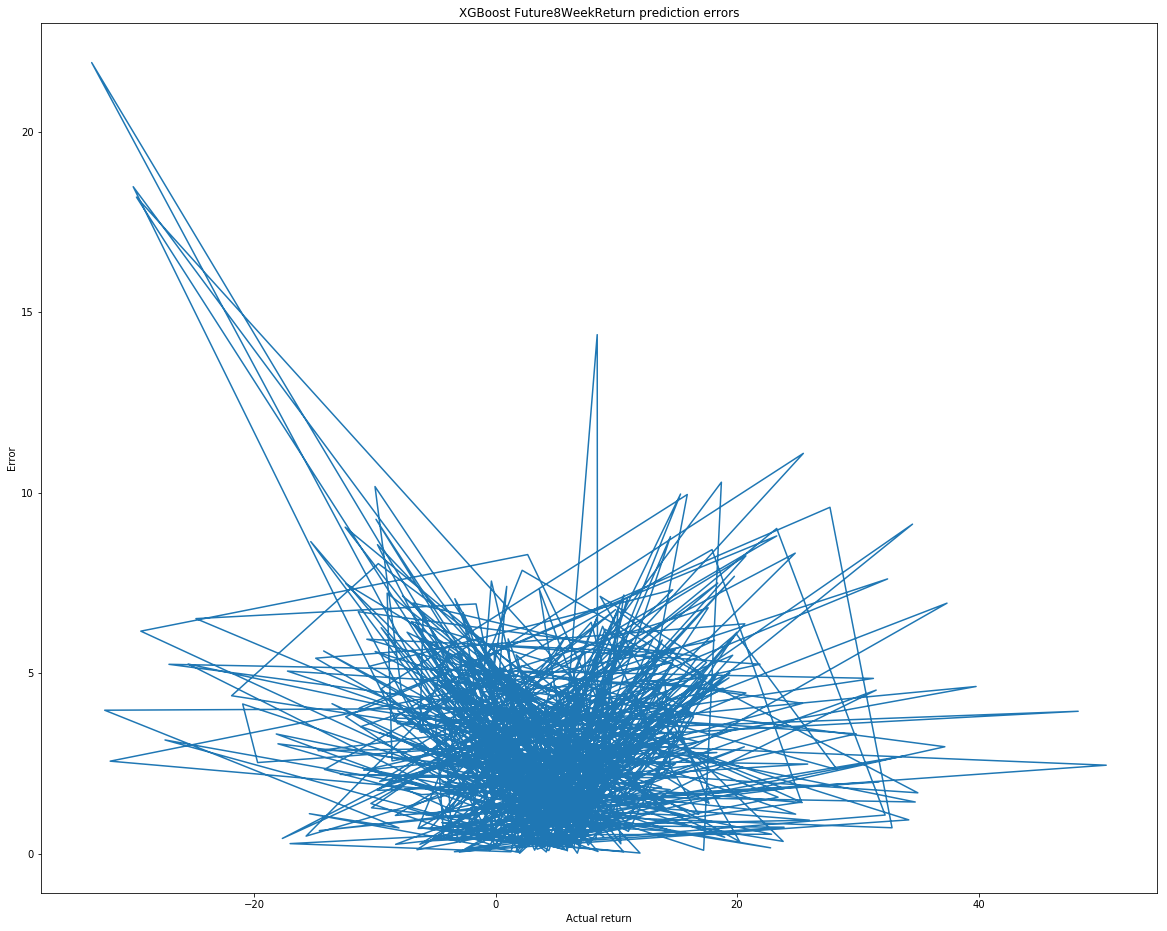

In [62]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
model = xgb.XGBRegressor(nthread=-1)
start = time.time()
model.fit(X_train, y_train)
elapsed = time.time() - start

# Output model settings
print(model)
print('Fit elapsed time: %d' % (elapsed))



start = time.time()
# make predictions for test data
predictions = model.predict(X_test)
elapsed = time.time() - start
print('Prediction elapsed time: %d' % (elapsed))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# ---------- 8 Week Returns ---------------------------------------------
    # --- All data ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  27.209411857320072

    # --- Removed outliers: n_estimators=100 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=100, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  23.8139769746

    # --- Removed outliers: n_estimators=200 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=200, nthread=1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9375376132

    # --- Removed outliers: n_estimators=500 ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #       learning_rate=0.1, max_delta_step=0, max_depth=3,
    #       min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
    #       objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #       scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Mean absolute error:  21.9761006957
    
    
# ---------- 8 Week Risk Adjusted Returns -------------------------------------
    # --- All data ---
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #   learning_rate=0.1, max_delta_step=0, max_depth=3,
    #   min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
    #   objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #   scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Fit elapsed time: 193
    # Prediction elapsed time: 3
    # Mean absolute error: 456.680567416


-99.82
756799.988323


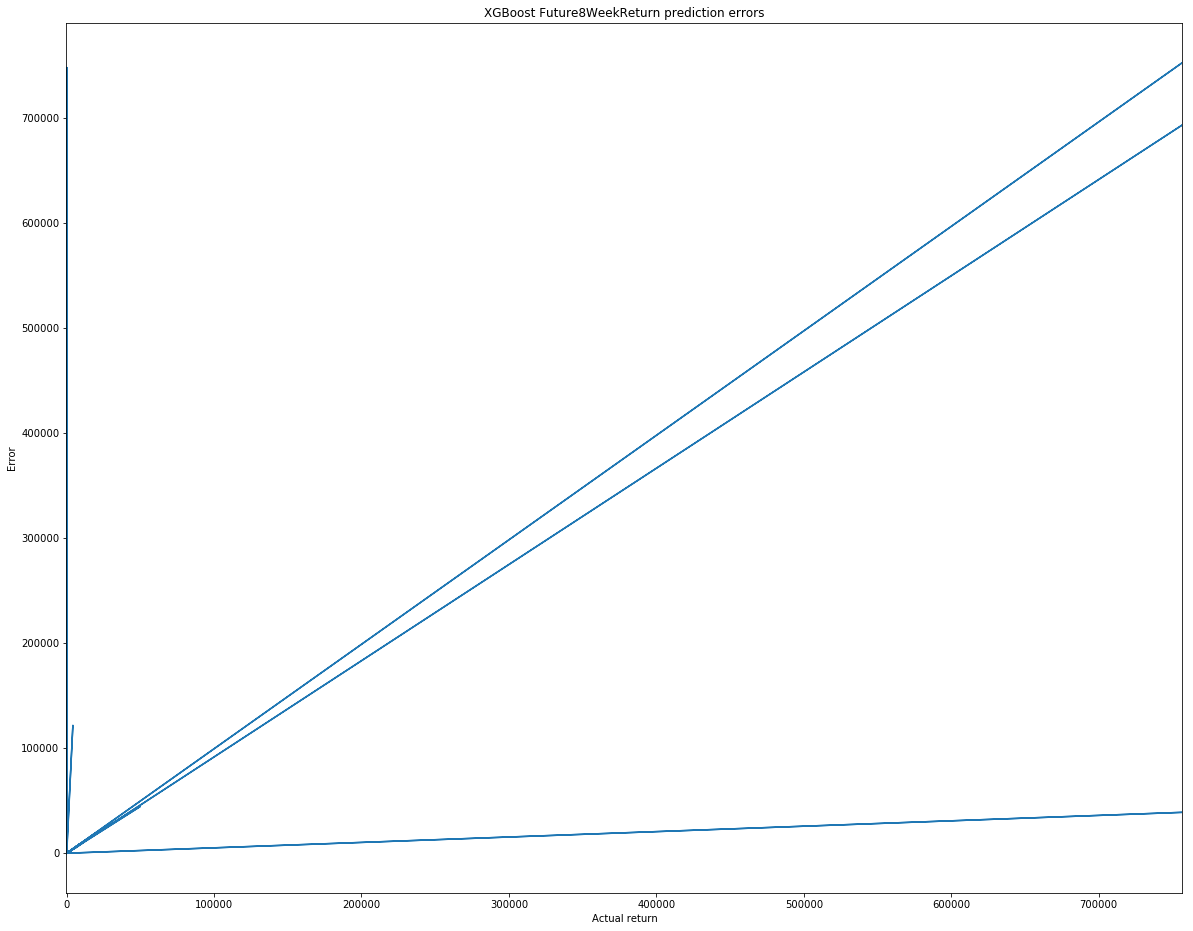

In [36]:
# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))

print( min(y_test))
print(max(y_test))


plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.xlim([ min(y_test),max(y_test)])
pyplot.title(plot_title)
pyplot.show(plot_title)

## Apply filter for specific symbol

In [56]:
# Run filter for CBA
include_symbols = ['CBA']
filtered_data = raw_data[raw_data['symbol'].isin(include_symbols)]
print(len(filtered_data))

2425


## Xgboost for one symbol

Training for Future8WeekReturn
XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)
Fit elapsed time: 2
Prediction elapsed time: 0
Mean absolute error: 1.82999759228


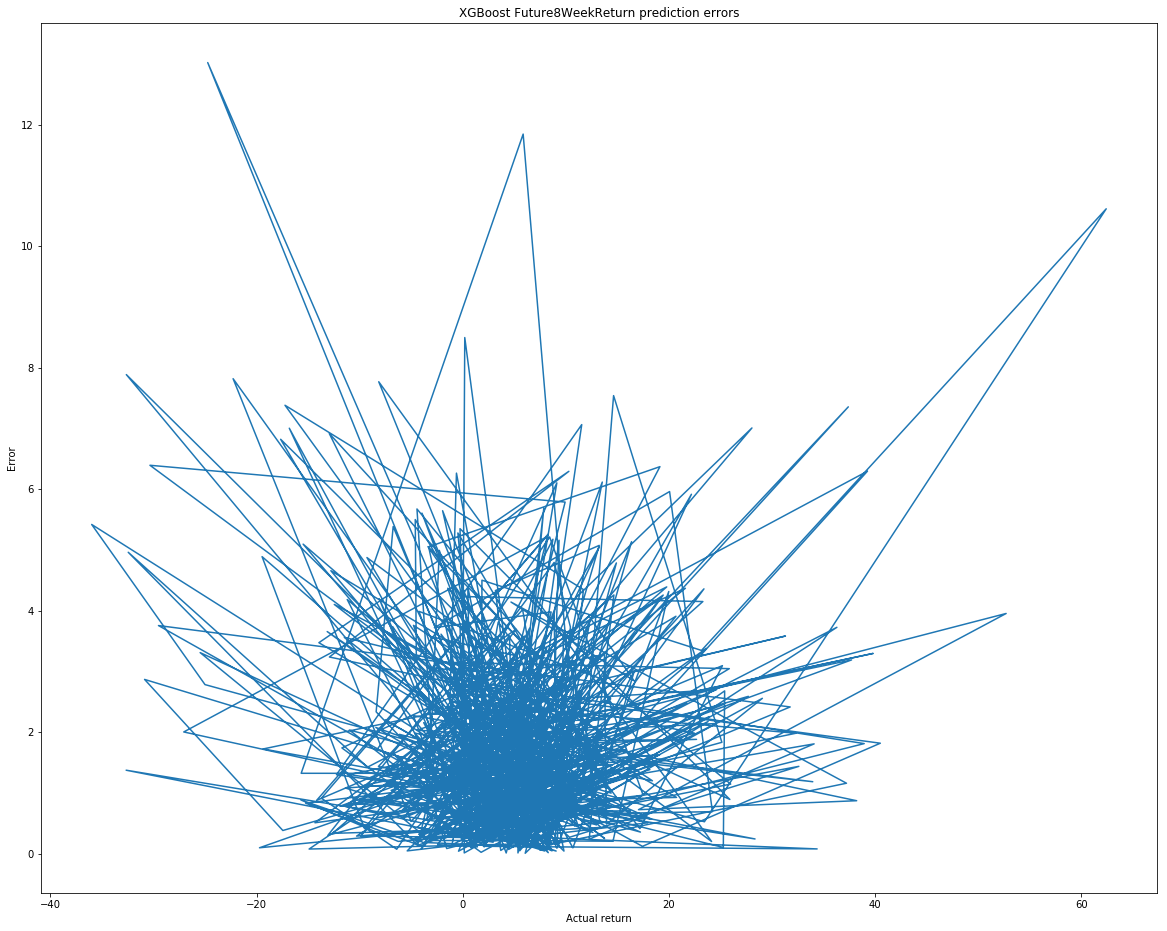

In [64]:
from sklearn.metrics import mean_absolute_error
import time

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

print('Training for', target_column)

# Fit model with training set
model = xgb.XGBRegressor(nthread=-1, n_estimators=1000)
start = time.time()
model.fit(X_train, y_train)
elapsed = time.time() - start

# Output model settings
print(model)
print('Fit elapsed time: %d' % (elapsed))



start = time.time()
# make predictions for test data
predictions = model.predict(X_test)
elapsed = time.time() - start
print('Prediction elapsed time: %d' % (elapsed))

# evaluate predictions
mae = mean_absolute_error(y_test, predictions)
print('Mean absolute error:', mae)

# Evaluate distribution of errors - get error amount for each prediction
y_errors = np.absolute(np.subtract(y_test, predictions))

# Plot the distribution of errors
pyplot.figure(figsize=(20, 16))
plot_title = 'XGBoost ' + target_column + ' prediction errors'
pyplot.plot(y_test, y_errors)
pyplot.ylabel('Error')
pyplot.xlabel('Actual return')
pyplot.title(plot_title)
pyplot.show(plot_title)

# ---------- 8 Week Returns - CBA  ---------------------------------------------
    # Training for Future8WeekReturn
    # XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
    #        learning_rate=0.1, max_delta_step=0, max_depth=3,
    #        min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
    #        objective='reg:linear', reg_alpha=0, reg_lambda=1,
    #        scale_pos_weight=1, seed=0, silent=True, subsample=1)
    # Fit elapsed time: 0
    # Prediction elapsed time: 0
    # Mean absolute error: 2.85405055196

#     Training for Future8WeekReturn
#     XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#            learning_rate=0.1, max_delta_step=0, max_depth=3,
#            min_child_weight=1, missing=None, n_estimators=500, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=1)
#     Fit elapsed time: 1
#     Prediction elapsed time: 0
#     Mean absolute error: 1.87473924615

#     Training for Future8WeekReturn
#     XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
#            learning_rate=0.1, max_delta_step=0, max_depth=3,
#            min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
#            objective='reg:linear', reg_alpha=0, reg_lambda=1,
#            scale_pos_weight=1, seed=0, silent=True, subsample=1)
#     Fit elapsed time: 2
#     Prediction elapsed time: 0
#     Mean absolute error: 1.82999759228

## Optimise single symbol model

In [ ]:
from sklearn.metrics import mean_absolute_error
import time

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

if __name__ == "__main__":
    print("Work through parameter optimization")

    # Split into train and test data
    X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3)

    
    model = xgb.XGBRegressor(nthread=-1)

    kfold = KFold(n_splits=5, shuffle=True)


    print("Set non-optimised baseline")
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(mean_absolute_error(actuals, predictions))

        print(np.mean(err))
        round_err.append(np.mean(err))

    baseline_error = np.mean(round_err)

    print("Average baseline error: %f" % baseline_error)
    print('-----')

    n_estimators=[7000, 7500, 8000, 8500, 9000, 9500, 10000]
        
    param_grid = dict(n_estimators=n_estimators)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    n_estimators_r = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        n_estimators_r.append(grid_result.best_params_['n_estimators'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    n_estimators = find_nearest(n_estimators_r, np.mean(n_estimators_r))
    
    model.n_estimators = n_estimators
    
    print("Averaged best n_estimators: %f " % n_estimators)
    print('-----')  
        
    model.n_estimators = n_estimators
    learning_rate = [0.025, 0.05, 0.075, 0.1, 0.2, 0.3]
    param_grid = dict(learning_rate=learning_rate)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    learning_rates = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        learning_rates.append(grid_result.best_params_['learning_rate'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    learning_rate = find_nearest(learning_rates, np.mean(learning_rates))
    
    model.learning_rate = learning_rate
    
    print("Averaged best learning rate: %f " % learning_rate)
    print('-----')     

    max_depth = [2, 4, 6, 8, 10, 12, 14]
    param_grid = dict(max_depth=max_depth)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    max_depths = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        max_depths.append(grid_result.best_params_['max_depth'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    max_depth = find_nearest(max_depths, np.mean(max_depths))
    
    model.max_depth = max_depth
    
    print("Averaged best max depth: %f " % max_depth)
    print('-----')
    samples = [0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1.0] #[i/100.0 for i in range(60,101, 5)]
    param_grid = dict(subsample=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    subsamples = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        subsamples.append(grid_result.best_params_['subsample'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    subsample = find_nearest(subsamples, np.mean(subsamples))
    
    model.subsample = subsample
    
    print("Averaged best subsample: %f " % subsample)
    print('-----')

    param_grid = dict(colsample_bytree=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bytrees = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bytrees.append(grid_result.best_params_['colsample_bytree'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bytree = find_nearest(colsample_bytrees, np.mean(colsample_bytrees))
    
    model.colsample_bytree = colsample_bytree
    
    print("Averaged best colsample_bytree: %f " % colsample_bytree)
    print('-----')

    param_grid = dict(colsample_bylevel=samples)

    grid_search = GridSearchCV(model,param_grid, scoring="neg_mean_absolute_error", cv=kfold, verbose=1, n_jobs=-1)
    colsample_bylevels = []

    for r in range(0, 5):
        grid_result = grid_search.fit(X_data, y_data)
        # summarize results
        print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
        colsample_bylevels.append(grid_result.best_params_['colsample_bylevel'])
        means = grid_result.cv_results_['mean_test_score']
        stds = grid_result.cv_results_['std_test_score']
        params = grid_result.cv_results_['params']

    colsample_bylevel = find_nearest(colsample_bylevels, np.mean(colsample_bylevels))
    
    model.colsample_bylevel = colsample_bylevel
    
    print("Averaged best colsample_bylevel: %f " % colsample_bylevel)
    print('-----')

    # Retest with new parameters
    round_err = []
    for r in range(0, 5):
        err = []
        for train_index, test_index in kfold.split(X_data):
            xgb_model = xgb.XGBRegressor(nthread=-1, colsample_bytree = colsample_bytree, 
                                         learning_rate = learning_rate, max_depth = max_depth, 
                                         n_estimators = n_estimators, subsample = subsample,
                                         colsample_bylevel = colsample_bylevel)
            xgb_model.fit(X_data[train_index],y_data[train_index])
            predictions = model.predict(X_data[test_index])
            actuals = y_data[test_index]
            err.append(mean_absolute_error(actuals, predictions))
               
        print(np.mean(err))
        round_err.append(np.mean(err))

    tuned_error = np.mean(round_err)

    print("Average tuned error: %s" % tuned_error)
    improvement = baseline_error - tuned_error
    print('-----')
    print('Optimisation improvement result: %s, %s%%' % (improvement, improvement / baseline_error * 100))
    print('-----')
    print(xgb_model)
    print('-----')

Work through parameter optimization
Set non-optimised baseline
2.76669510198
2.77059582514
2.76793118695
2.75707773924
2.78502946254
Average baseline error: 2.769466
-----
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.3min finished


Best: -1.704491 using {'n_estimators': 9500}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.2min finished


Best: -1.675956 using {'n_estimators': 10000}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.0min finished


Best: -1.627424 using {'n_estimators': 8000}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  5.0min finished


Best: -1.664513 using {'n_estimators': 9000}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.9min finished


Best: -1.699846 using {'n_estimators': 10000}
Averaged best n_estimators: 9500.000000 
-----
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 136.2min finished


Best: -1.650047 using {'learning_rate': 0.075}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


Best: -1.659872 using {'learning_rate': 0.1}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 19.6min finished


Best: -1.687457 using {'learning_rate': 0.1}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


Best: -1.655150 using {'learning_rate': 0.05}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  4.2min finished


Best: -1.642813 using {'learning_rate': 0.025}
Averaged best learning rate: 0.075000 
-----
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.8min finished


Best: -1.530964 using {'max_depth': 12}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  3.8min finished


Best: -1.534193 using {'max_depth': 12}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed: 20.2min finished


Best: -1.537335 using {'max_depth': 6}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.3min finished


Best: -1.525720 using {'max_depth': 8}
Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:  4.1min finished


Best: -1.482705 using {'max_depth': 10}
Averaged best max depth: 10.000000 
-----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.8min finished


Best: -1.472118 using {'subsample': 0.85}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.9min finished


Best: -1.479732 using {'subsample': 0.75}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.7min finished


Best: -1.507496 using {'subsample': 0.85}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.8min finished


Best: -1.506154 using {'subsample': 0.8}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  4.6min finished


Best: -1.471964 using {'subsample': 0.75}
Averaged best subsample: 0.800000 
-----
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:  3.6min finished


Best: -1.474498 using {'colsample_bytree': 0.8}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 42.5min finished


Best: -1.447278 using {'colsample_bytree': 0.8}
Fitting 5 folds for each of 9 candidates, totalling 45 fits


## Data checks

In [ ]:
# Check correlations 
filtered_data[data_columns].corr()
